#Train embeddings with SparkNLP and Gensim

###Single Corpus Indicators
Number of Sentences (NoS)  
Sentence Length Distribution (Avg, Std)  
Ngrams Sorted by Ocurrence  
Distinct n-grams (1:n)  
###Joined Corpora Indicators 
Target n-grams coverage

In [3]:
from pyspark.sql.functions import regexp_replace, substring
from pyspark.sql.types import StringType, StructType, StructField

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.util import *
from sparknlp.embeddings import *

from gensim.models import Word2Vec
from nltk.util import ngrams

import json, re, csv, os, pprint, pandas as pd
from matplotlib import pyplot as plt

Some parameters to drive notebook's execution  
**sample_size**: Is how big the train data would be compared to the whole dataset (in terms of sentences)  
**stopwords_path**: Path to a list of words that need not to be included in the vocabulary  
**min_sentence_length**: Minimum number of words in a sentence to be considered for the corpus  
**max_acronym_size**: Max length of a word to be considered as an acronym if written in caps  
**special**: List of tuples with compiled regexes and substitution string (regexp_string, replace_string)  
**ngram_depth**: Up to how many words should the tokens contain for ngrams  
**with_indicators**: Whether to calculate indicators or not  
**project_path**: Folder to store the training corpus  
**include_target**: Whther to include target dataset in the corpus

In [5]:
#Performance parameters
sample_size = 50/100
repartition = max(15e9/100e6*sample_size, 300)

#Prepare parameters
stopwords_path = "/dbfs/andres/stopwords.txt"
min_sentence_length = 5
max_acronym_size = 5
special = [(re.compile(regexp), rep_str) for regexp, rep_str in
  [
    (r"^(?:(?:31(\/|-|\.)(?:0?[13578]|1[02]))\1|(?:(?:29|30)(\/|-|\.)(?:0?[1,3-9]|1[0-2])\2))(?:(?:1[6-9]|[2-9]\d)?\d{2})$|^(?:29(\/|-|\.)0?2\3(?:(?:(?:1[6-9]|[2-9]\d)?(?:0[48]|[2468][048]|[13579][26])|(?:(?:16|[2468][048]|[3579][26])00))))$|^(?:0?[1-9]|1\d|2[0-8])(\/|-|\.)(?:(?:0?[1-9])|(?:1[0-2]))\4(?:(?:1[6-9]|[2-9]\d)?\d{2})$", "##date##"),
    #(r"^-?[0-9]+[,.]?[0-9]*([\/][0-9]+[,.]?[0-9]*)+", "##frac##"),
    (r"^-\d+$", "##int-##"),
    (r"^\d+$", "##int+##"),
    (r"^-\d*[.,]\d+$", "##dec-##"),
    (r"^\d*[.,]\d+$", "##dec+##"),
    (r"[^a-zA-Z0-9 \-#%'?]", " "),
    (r"(\ufeff|\u2003a|\xa0|\u2009)", " "),
    (r"[.,;\[\]\"\'\(\)]", " "),
    (r"\s{2,}", " ")
  ]
]

ngram_depth = 2
with_indicators = True
include_target = False
project_path = "PATH/TO/TRAINING/FOLDER"
target_file = "/andres/case_studies/corpora/*.txt.gz"
num_dims, skipgram, training_window, min_token_count, num_workers, epochs = 400, 1, 5, 5, 16, 5

##Read the data

Read all the data you will be using to create the corpus  
The idea for this section is to have the data in a Spark DataFrame with "id"and "description" fields in order to Transform it

In [8]:
full_data_txt = sc.textFile(target_file)

In [9]:
def prepare(tuple2):
  y = list(tuple2)
  if len(y) == 2:
    y[1] = y[1] if len(y[1]) <= max_acronym_size and y[1]==y[1].upper() else y[1].lower() #preserve upper acronyms if shorter than max_acronym_size
    for s in special:
      y[1] = s[0].sub(s[1], y[1])
  else:
    y = ("", "")
  return y
def split_and_prepare(x):
  return prepare(x.split("||||"))

train_txt = full_data_txt.sample(True, sample_size, seed=85).repartition(repartition).map(split_and_prepare)

target_df = spark.read.csv("/andres/icd10/icd10cm.csv", header=True).rdd.map(prepare).toDF(["id","description"])
train_df = train_txt.toDF(["id", "description"])
if include_target:
  train_df = train_txt.toDF(["id", "description"]).union(target_df).union(target_df).union(target_df).union(target_df).union(target_df)

## Transform the data

NLP Processing

In [12]:
documentAssembler = DocumentAssembler()\
  .setInputCol("description")\
  .setOutputCol("document")\
  .setCleanupMode("shrink_full")

tokenizer = Tokenizer()\
  .setInputCols(["document"])\
  .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained("lemma_antbnc", "en", "public/models")\
  .setInputCols(["token"])\
  .setOutputCol("lemma")

#Model
nlp_pipeline = Pipeline(stages=[documentAssembler,
                                #sentenceDetector,
                                tokenizer,lemmatizer]).fit(train_df)
preprocessed = nlp_pipeline \
    .transform(train_df)

Load stopwords file (list of words)

In [14]:
with open(stopwords_path, "r") as f:
  clinical_sw = [i[0] for i in csv.reader(f)]
len(clinical_sw)

Out[ 70 ]: 811

Formatting for Word2Vec training while removing stopwords

In [16]:
tokenized_sentences = preprocessed.select("lemma").rdd.zipWithIndex() \
  .flatMap(lambda a: [(a[1],int(i[4]["sentence"]),i[3]) for i in a[0][0] if i[3] not in clinical_sw]+[(a[1],int(i[4]["sentence"]),i[3]) for i in a[0][0] if i[3]]) \
  .groupBy(lambda a: (a[0],a[1])) \
  .map(lambda a: ([z[2] for z in a[1]])) \
  .filter(lambda x: len(x)>=min_sentence_length) \
  .cache()

Calculate some basic indicators for training corpus

In [18]:
if with_indicators:
  num_of_words_x_sentence = tokenized_sentences.map(lambda x: len(x)).cache()
  ind_num_of_sentences = tokenized_sentences.count()
  ind_min_sentence_len = num_of_words_x_sentence.min()
  ind_avg_sentence_len = num_of_words_x_sentence.mean()
  ind_max_sentence_len = num_of_words_x_sentence.max()
  ind_std_sentence_len = num_of_words_x_sentence.stdev()
  print("Sentences: ",ind_num_of_sentences," | Min Sentence Length: ",ind_min_sentence_len," | Avg. Sentence Length: ",round(ind_avg_sentence_len,2)," | Max. Sentence Length: ",ind_max_sentence_len," | Std. Sentence Length: ",round(ind_std_sentence_len,2))
  num_of_words_x_sentence.unpersist();

Sentences: 1311232 | Min Sentence Length: 5 | Avg. Sentence Length: 65.96 | Max. Sentence Length: 2462 | Std. Sentence Length: 95.28

In [19]:
len_dist = pd.Series(num_of_words_x_sentence.collect())

In [20]:
print(len(len_dist[len_dist<100]))

1030734

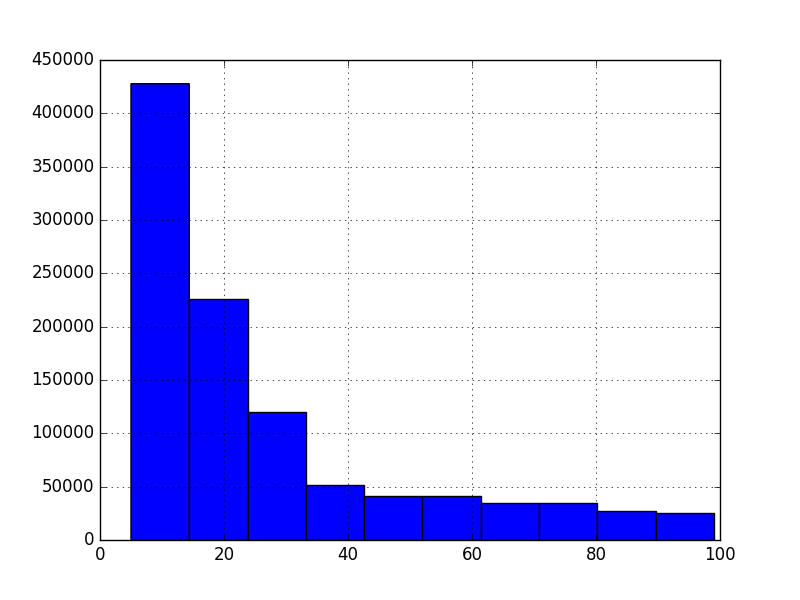

In [21]:
fig = plt.figure()
len_dist[len_dist<100].hist()
display(fig)

**build_ngrams** function builds ngrams for each sentence up to **ngram_depth** and stores them in an array with one dimension for each set of ngrams  
**get_ngram_count** and **get_ngram_count** are convenient functions to calculate ngram counts

In [23]:
def build_ngrams(sentence, ng_depth):
  ngram_col = []
  for n in range(1,ng_depth+1):
    current_ngrams = [(wi,1) for wi in sentence] if n==1 else [("_".join(ng),1) for ng in ngrams(sentence, n) if ng]
    ngram_col.append(current_ngrams)
  return ngram_col

def get_ngram_count(ng_sentences, n):
  return ng_sentences.flatMap(lambda x: x[n-1]).reduceByKey(lambda x, y: x + y)

def get_ngram_count_list(ng_sentences):
  ngrams_list = []
  for i in range(ngram_depth):
    current_ngram_list = get_ngram_count(ng_sentences,i+1)
    ngrams_list.append(current_ngram_list)
  return ngrams_list

**ngram_permutation** allows multiple ways to rearrange the ngrams in the corpus to start training:  
- False, False: [k_grams] + [k+1_grams] + [k+2_grams]...
- False, True:  [k_igrams]
- True, True:   [unigrams] + [k_igrams]

In [25]:
def ngram_permutation(ns, with_original=True, merge=True):
  #Create a meaningful permutation
  sentence, ng_depth = ns[0], len(ns)
  flattened, n_words = [], len(sentence)
  if with_original:
    flattened = [w for w,c in ns[0]]
  if merge:
    for i, s in enumerate(sentence):
      for ngi in range(min(ng_depth, n_words-i)):
        flattened.append(ns[ngi][i][0])
  else:
    for s in ns:
      for ng, c in s:
        flattened.append(ng)
  return flattened
ngram_sentences = tokenized_sentences.map(lambda s: build_ngrams(s, ngram_depth)).cache()
training_sentences = ngram_sentences.map(lambda x: ngram_permutation(x, False, False))

In [26]:
training_sentences.top(1000)

Out[ 78 ]: [['zziwa',
 'gb',
 'review',
 'tetanus',
 'admission',
 'rural',
 'ugandan',
 'hospital',
 'health',
 'policy',
 'development',
 '2009',
 '7',
 '3',
 '199',
 '202',
 'google',
 'scholar',
 'zziwa',
 'gb',
 'review',
 'of',
 'tetanus',
 'admission',
 'to',
 'a',
 'rural',
 'ugandan',
 'hospital',
 'health',
 'policy',
 'and',
 'development',
 '2009',
 '7',
 '3',
 '199',
 '202',
 'google',
 'scholar',
 'zziwa_gb',
 'gb_review',
 'review_tetanus',
 'tetanus_admission',
 'admission_rural',
 'rural_ugandan',
 'ugandan_hospital',
 'hospital_health',
 'health_policy',
 'policy_development',
 'development_2009',
 '2009_7',
 '7_3',
 '3_199',
 '199_202',
 '202_google',
 'google_scholar',
 'scholar_zziwa',
 'zziwa_gb',
 'gb_review',
 'review_of',
 'of_tetanus',
 'tetanus_admission',
 'admission_to',
 'to_a',
 'a_rural',
 'rural_ugandan',
 'ugandan_hospital',
 'hospital_health',
 'health_policy',
 'policy_and',
 'and_development',
 'development_2009',
 '2009_7',
 '7_3',
 '3_199',
 '199_202',
 '202_google',
 'google_scholar'],
 ['zziwa',
 'gb',
 'review',
 'tetanus',
 'admission',
 'rural',
 'ugandan',
 'hospital',
 'health',
 'policy',
 'development',
 '2009',
 '7',
 '3',
 '199',
 '202',
 'google',
 'scholar',
 'zziwa',
 'gb',
 'review',
 'of',
 'tetanus',
 'admission',
 'to',
 'a',
 'rural',
 'ugandan',
 'hospital',
 'health',
 'policy',
 'and',
 'development',
 '2009',
 '7',
 '3',
 '199',
 '202',
 'google',
 'scholar',
 'zziwa_gb',
 'gb_review',
 'review_tetanus',
 'tetanus_admission',
 'admission_rural',
 'rural_ugandan',
 'ugandan_hospital',
 'hospital_health',
 'health_policy',
 'policy_development',
 'development_2009',
 '2009_7',
 '7_3',
 '3_199',
 '199_202',
 '202_google',
 'google_scholar',
 'scholar_zziwa',
 'zziwa_gb',
 'gb_review',
 'review_of',
 'of_tetanus',
 'tetanus_admission',
 'admission_to',
 'to_a',
 'a_rural',
 'rural_ugandan',
 'ugandan_hospital',
 'hospital_health',
 'health_policy',
 'policy_and',
 'and_development',
 'development_2009',
 '2009_7',
 '7_3',
 '3_199',
 '199_202',
 '202_google',
 'google_scholar'],
 ['zz',
 'right-handed',
 'male',
 'bear',
 'sweden',
 '1932',
 'admit',
 'stroke',
 'clinic',
 'malm',
 'university',
 'hospital',
 '1',
 'april',
 '2004',
 'diagnose',
 'cerebral',
 'infarct',
 'due',
 'posterior',
 'cerebral',
 'artery',
 'stroke',
 'ct',
 'scan',
 'perform',
 '6',
 'april',
 '2004',
 'show',
 'low',
 'attenuate',
 'area',
 'leave',
 'occipital',
 'lobe',
 'neurological',
 'examination',
 'reveal',
 'right-sided',
 'homonymous',
 'hemianopia',
 'visual',
 'perceptual',
 'deficit',
 'base',
 'language',
 'test',
 'stroke',
 'papap',
 'apt',
 '1997',
 'swedish',
 'equivalent',
 'boston',
 'diagnostic',
 'aphasia',
 'examination',
 'sbp',
 'apt',
 '1999',
 'swedish',
 'equivalent',
 'boston',
 'name',
 'test',
 'diagnose',
 'light',
 'moderate',
 'anomic',
 'aphasia',
 'include',
 'semantic',
 'dyslexia',
 'alexia',
 'agraphia',
 'zz',
 'auditory',
 'language',
 'comprehension',
 'normal',
 'limit',
 'speech',
 'fluent',
 'normal',
 'syntax',
 'phonology',
 'mild',
 'moderate',
 'anomia',
 'difficulty',
 'find',
 'proper',
 'name',
 'produce',
 'verbal',
 'semantic',
 'paraphasias',
 'full',
 'evaluation',
 'name',
 'ability',
 'discontinue',
 'sbp',
 'test',
 'complete',
 'zz',
 'be',
 'a',
 'right-handed',
 'male',
 'bear',
 'in',
 'sweden',
 'in',
 '1932',
 'he',
 'be',
 'admit',
 'to',
 'the',
 'stroke',
 'clinic',
 'at',
 'malm',
 'university',
 'hospital',
 'on',
 '1',
 'april',
 '2004',
 'and',
 'diagnose',
 'with',
 'a',
 'cerebral',
 'infarct',
 'due',
 'to',
 'a',
 'posterior',
 'cerebral',
 'artery',
 'stroke',
 'a',
 'ct',
 'scan',
 'perform',
 'on',
 '6',
 'april',
 '2004',
 'show',
 'a',
 'low',
 'attenuate',
 'area',
 'in',
 'the',
 'leave',
 'occipital',
 'lobe',
 'neurological',
 'examination',
 'reveal',
 'a',
 'right-sided',
 'homonymous',
 'hemianopia',
 'but',
 'no',
 'visual',
 'perceptual',
 'deficit',
 'base',
 'on',
 'language',
 'test',
 'after',
 'the',

In [27]:
if with_indicators:
  ngram_count_list = get_ngram_count_list(ngram_sentences)
tokenized_sentences.unpersist();

In [28]:
if with_indicators:
  for i,ngl in enumerate(ngram_count_list):
    print("{}-grams count".format(i+1))
    pprint.pprint(ngl.takeOrdered(30,lambda x: -x[1]))
    print()

1-grams count
[('the', 2610886),
 ('of', 2171551),
 ('be', 1785859),
 ('and', 1646707),
 ('in', 1138557),
 ('a', 1109557),
 ('to', 773524),
 ('with', 767631),
 ('case', 619704),
 ('patient', 462777),
 ('report', 438790),
 ('for', 421090),
 ('1', 398574),
 ('2', 342290),
 ('have', 327510),
 ('show', 318580),
 ('treatment', 268010),
 ('cell', 265990),
 ('3', 263902),
 ('we', 263261),
 ('present', 255956),
 ('by', 252508),
 ('disease', 250382),
 ('as', 245880),
 ('that', 240181),
 ('this', 223494),
 ('an', 221888),
 ('tumor', 220866),
 ('on', 215162),
 ('5', 210738)]

2-grams count
[('of_the', 467194),
 ('in_the', 303968),
 ('the_patient', 150318),
 ('to_the', 124624),
 ('google_scholar', 122758),
 ('case_report', 101599),
 ('patient_with', 100589),
 ('and_the', 98211),
 ('case_of', 93398),
 ('be_a', 92756),
 ('have_be', 89427),
 ('of_a', 83522),
 ('with_a', 83248),
 ('in_a', 79044),
 ('on_the', 68660),
 ('from_the', 59124),
 ('crossref_google', 58380),
 ('pubmed_crossref', 57846),
 ('pubmed_google', 57831),
 ('associate_with', 57695),
 ('due_to', 57569),
 ('doi_10', 57482),
 ('patient_be', 57346),
 ('there_be', 55973),
 ('be_the', 54357),
 ('a_case', 52827),
 ('to_be', 52570),
 ('with_the', 51978),
 ('for_the', 51956),
 ('at_the', 50483)]

Check the low frequency words for some issues in the regex preprocessing

More indicators on the way...

Target Coverage indicator before actually training. Load the target dataset in which the embeddings will be tested.

In [32]:
target_df = spark.read.csv(target_file, header=True).rdd.map(prepare).toDF(["id","description"])

Apply the same pipeline to the target dataset and grab the words

In [34]:
target_ngram_sentences = nlp_pipeline.transform(target_df).select("lemma").rdd.map(lambda w: [wi["result"] for wi in w[0]]).map(lambda s: build_ngrams(s, ngram_depth)).cache()

In [35]:
target_ngram_count_list = get_ngram_count_list(target_ngram_sentences)

In [36]:
if with_indicators:
  for i,ngl in enumerate(target_ngram_count_list):
    print("{}-grams count".format(i+1))
    pprint.pprint(ngl.takeOrdered(30,lambda x: -x[1]))
    print()

1-grams count
[('of', 68223),
 ('encounter', 36313),
 ('fracture', 33397),
 ('unspecified', 25346),
 ('subsequent', 21820),
 ('with', 20645),
 ('for', 16864),
 ('other', 14566),
 ('initial', 14198),
 ('leave', 13396),
 ('right', 13226),
 ('sequela', 12079),
 ('and', 11112),
 ('or', 9277),
 ('in', 7160),
 ('open', 7031),
 ('type', 6560),
 ('healing', 6030),
 ('displace', 5312),
 ('nondisplaced', 5265),
 ('injury', 4454),
 ('to', 4300),
 ('low', 3896),
 ('close', 3822),
 ('shaft', 3412),
 ('injure', 3258),
 ('level', 3193),
 ('at', 3107),
 ('by', 3065),
 ('delay', 3048)]

2-grams count
[('subsequent_encounter', 21773),
 ('encounter_for', 16105),
 ('fracture_of', 15754),
 ('initial_encounter', 14187),
 ('of_unspecified', 10159),
 ('of_right', 8251),
 ('of_leave', 8250),
 ('fracture_with', 7705),
 ('open_fracture', 6152),
 ('for_open', 6152),
 ('for_fracture', 5783),
 ('fracture_type', 5100),
 ('close_fracture', 3821),
 ('for_close', 3821),
 ('injury_of', 3770),
 ('of_shaft', 3410),
 ('shaft_of', 3410),
 ('with_delay', 3024),
 ('with_routine', 3015),
 ('routine_healing', 3015),
 ('delay_healing', 3015),
 ('with_nonunion', 2997),
 ('type_i', 2833),
 ('displace_fracture', 2709),
 ('end_of', 2704),
 ('injure_in', 2703),
 ('nondisplaced_fracture', 2688),
 ('with_malunion', 2662),
 ('of_other', 2652),
 ('i_or', 2551)]

Calculate corpora intesection for each ngram list (train vs target)

In [38]:
if with_indicators:
  ind_ngram_dcount = []
  ind_target_ngram_dcount = []
  ind_ngram_coverage = []
  for i in range(ngram_depth):
    indc = ngram_count_list[i].count()
    intdc = target_ngram_count_list[i].count()
    incvrg = target_ngram_count_list[i].join(ngram_count_list[i]).count() / intdc
    ind_ngram_dcount.append(indc)
    ind_target_ngram_dcount.append(intdc)
    ind_ngram_coverage.append(incvrg)
    print(" ".join(["Distinct {i}-gram corpus:", str(indc), "Distinct {i}-gram target:", str(intdc), "->", "% of {i}-gram target in corpus:", str(incvrg)]).format(**{"i": i+1}))

  ngram_sentences.unpersist();
  target_ngram_sentences.unpersist();

Distinct 1-gram corpus: 521611 Distinct 1-gram target: 6860 -> % of 1-gram target in corpus: 0.9425655976676385
Distinct 2-gram corpus: 9790451 Distinct 2-gram target: 25944 -> % of 2-gram target in corpus: 0.6299337033610855

In [39]:
if with_indicators:
  indicators = {
    "ind_num_of_sentences": ind_num_of_sentences,
    "ind_min_sentence_len": ind_min_sentence_len,
    "ind_avg_sentence_len": ind_avg_sentence_len,
    "ind_max_sentence_len": ind_max_sentence_len,
    "ind_std_sentence_len": ind_std_sentence_len,
    "ind_ngram_dcount": ind_ngram_dcount,
    "ind_target_ngram_dcount": ind_target_ngram_dcount,
    "ind_ngram_coverage": ind_ngram_coverage
  }
  pprint.pprint(indicators)

{'ind_avg_sentence_len': 65.95778219468644,
 'ind_max_sentence_len': 3023,
 'ind_min_sentence_len': 5,
 'ind_ngram_coverage': [0.9540816326530612, 0.6635060129509713],
 'ind_ngram_dcount': [681483, 13402970],
 'ind_num_of_sentences': 2621240,
 'ind_std_sentence_len': 95.37537845244312,
 'ind_target_ngram_dcount': [6860, 25944]}

If indicators are satisfactory, proceed. Otherwise adjust the corpus and repeat.

In [41]:
path_suffix = "_{}_{}ng_{}d_{}w_{}min_{}smpl_{}epochs".format("skipgram" if skipgram else "cob", ngram_depth, num_dims, training_window, min_token_count, int(sample_size*10000)/100, epochs)
path_suffix

Out[ 68 ]: '_skipgram_2ng_400d_5w_5min_49.99smpl_5epochs'

In [42]:
train_corpus_path = os.path.join(project_path, "training", "train_corpus"+path_suffix+".txt")
partial_train_corpus_path = re.sub("^/dbfs","",train_corpus_path)

try:
  dbutils.fs.ls(partial_train_corpus_path)
  dbutils.fs.rm(partial_train_corpus_path, True)
except:
  pass

training_sentences.map(lambda x: " ".join(x)).coalesce(1).saveAsTextFile(partial_train_corpus_path)

dbutils.fs.mv(partial_train_corpus_path+"/part-00000", partial_train_corpus_path+"_")
dbutils.fs.rm(partial_train_corpus_path, True)
dbutils.fs.mv(partial_train_corpus_path+"_", partial_train_corpus_path)

Out[ 69 ]: True

In [43]:
model = Word2Vec(corpus_file=train_corpus_path, size=num_dims, window=training_window, min_count=min_token_count, workers=num_workers, sg=skipgram, iter=epochs)

Persist all the important information: Embeddings Vectors and Corpora Indicators

In [45]:
base_model_path = os.path.join(project_path,"models")
model_path = os.path.join(base_model_path,"vectors"+path_suffix+".bin")
model.wv.save_word2vec_format(model_path, binary=True)           
  
if with_indicators:
  ngram_path = os.path.join(base_model_path,"ngrams"+path_suffix+".txt")
  with open(ngram_path, "wb") as f:
    pickle.dump([ng.collect() for ng in ngram_count_list], f)     
  indicators_path = os.path.join(base_model_path,"indicators"+path_suffix+".txt")
  with open(indicators_path, "wb") as f:
    pickle.dump(indicators, f)                                                                                